## Summary
This project performs clustering analysis using a few factors, then use the clustersfor "classification neutral" stock selction. We will compare this neutrality strategy to a more traditional sector neutral strategy.

### 1. Import package & variables setup

In [4]:
import pandas as pd
import numpy as np
from os import path
import os

# import KMeans
from sklearn.cluster import KMeans

# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# set sql connection
import pyodbc
server = 'RIC1D2RSGSQL01' 
database = 'EquityResearch' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

# data viz packages
import matplotlib.pyplot as plt
import plotly.graph_objects as plty
from plotly.subplots import make_subplots

In [5]:
clr1 = ["#00ab4e","#58595b","#939598","#000000","#FFFFFF"]
clr2 = ["#009697","#8dc63f","#f7941d","#ee2f53","#00b5f1","#96157c","#00ab4e","#58595b"]

sc_path = os.path.expanduser("~\\OneDrive - IHS Markit\\ResearchSignals\\Projects\\20200213_StockClustering")
file1 = 'Factor_data_USLC_2019.txt'
file2 = 'Factor_data_USTC_2019.txt'
file3 = 'Factor_data_USLC_2010to2019.txt'


### 2. Load data

In [6]:
sc_data = pd.read_csv(path.join(sc_path,file3), sep='\t')
sc_data.head()

Date  FactorId SecurityId  Rank  RawRatio
0  2010-04-30 00:00:00         5   05564E10  1919       NaN
1  2010-04-30 00:00:00         5   11246310   811       NaN
2  2010-04-30 00:00:00         5   12526910  3165       NaN
3  2010-04-30 00:00:00         5   13645T10  1718       NaN
4  2010-04-30 00:00:00         5   20451N10  1415       NaN

Factor & ID mapping

|Factor Group|Factor|Factor ID|Factor Name|
|------------|------|---------|-----------|
|Profitability|ROIC|249|Return on Invested Capital|
|Profitability|FCFROI|146|Free Cash Flow Return on Invested Capital|
|Profitability|GPM|7408|TTM Gross Profit Margin|
|Valuation|EBITDAP|106|TTM EV/EBITDA|
|Valuation|TTMSP|304|TTM Price to Sale|
|Valuation|BP|29|Book-to-Market|
|Momentum|ActRtn12M|5|12-Month Active Return with 1-month Lag|
|Momentum|ActRtn3M|11|3-Month Active Return with 1-month Lag|
|Momentum|FF10MRtn|148|Fama-French Momentum|
|Management Quality|ChgShare|73|Percent Change in Shares Outstanding|


In [12]:
# create dict for factor id to name mapping
fac_dict = {5:'ActRtn12M',
            11:'ActRtn3M',
            29:'BP',
            73:'ChgShare',
            106:'EBITDAP',
            146:'FCFROI',
            148:'FF10MRtn',
            249:'ROIC',
            304:'TTMSP',
            7408:'GPM'}

In [7]:
# test = sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & (sc_data.FactorId == 29),]
# test.shape

sc_data.groupby(['Date','FactorId']).Rank.median()

Date                 FactorId
2010-01-29 00:00:00  5           2418.0
                     11          2648.5
                     29          2540.0
                     73          1978.5
                     106         1976.0
                                  ...  
2020-02-17 00:00:00  146         2569.5
                     148         5331.0
                     249         2636.0
                     304         5318.0
                     7408        3532.0
Name: Rank, Length: 1190, dtype: float64

In [8]:
# Creating crosssectional ranking columns

sc_data['cs_PRank'] = sc_data.groupby(['Date','FactorId']).Rank.rank(pct=True)

sc_data.sort_values(['Date','SecurityId']).head()
sc_data[(sc_data.SecurityId == 'AAPL') & (sc_data.Date == '2019-01-31 00:00:00')]

# double check the percentile ranck, look good
# sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & 
#             (sc_data.FactorId == 29) & 
#             (sc_data.prank < 0.05),].sort_values(['prank'])



Date  FactorId SecurityId  Rank  RawRatio  cs_PRank
1148159  2019-01-31 00:00:00         5       AAPL  5246  -0.55232  0.421053
1157934  2019-01-31 00:00:00        11       AAPL  2443 -23.66965  0.027903
1171378  2019-01-31 00:00:00        29       AAPL  7908   0.14976  0.780576
1177578  2019-01-31 00:00:00        73       AAPL   184  -6.92400  0.069343
1182623  2019-01-31 00:00:00       106       AAPL  3857   0.10566  0.475931
1187628  2019-01-31 00:00:00       146       AAPL   443   0.22548  0.079638
1194420  2019-01-31 00:00:00       148       AAPL  3020   6.65950  0.299908
1206185  2019-01-31 00:00:00       249       AAPL   391   0.28977  0.067766
1214474  2019-01-31 00:00:00       304       AAPL  5785   0.32625  0.606115
1221702  2019-01-31 00:00:00      7408       AAPL  4568   0.42625  0.645355

In [9]:
test = sc_data[sc_data.FactorId == 29].RawRatio
test.shape

(131896,)

### 3. Examine data

In [16]:
### pivot table the data to have factors as columns and PRank as values
a = sc_data.pivot_table(index=[pd.to_datetime(sc_data.Date),'SecurityId'], columns='FactorId', values='cs_PRank', fill_value = 0)

type(a)
a.rename(columns = fac_dict, inplace = True)
a.head()

FactorId               ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2010-01-29 00163T10     0.348240  0.682075  0.200573  0.975048  0.878049   
           00184X10     0.000000  0.000000  0.060172  0.000000  0.956098   
           00766T10     0.890580  0.468868  0.384909  0.816699  0.426829   
           01527110     0.843007  0.722642  0.202483  0.962572  0.341463   
           01858110     0.436727  0.578302  0.960840  0.006718  0.309756   

FactorId                 FCFROI  FF10MRtn      ROIC     TTMSP       GPM  
Date       SecurityId                                                    
2010-01-29 00163T10    0.915466  0.547098  0.855086  0.910612  0.083241  
           00184X10    0.145053  0.000000  0.975048  0.221797  0.318535  
           00766T10    0.476465  0.888677  0.360845  0.106119  0.973363  
           01527110    0.910663  0.948620  0.729367  0.893881  0.117647  
           01858110    0.723343  0.394862  0.309021  0.599904  0.721976

In [17]:
b = a.loc['2019-01-31']
b.index.names
b.index

MultiIndex([('2019-01-31', '00090Q10'),
            ('2019-01-31', '00163T10'),
            ('2019-01-31', '00164V10'),
            ('2019-01-31', '00287Y10'),
            ('2019-01-31', '00766T10'),
            ('2019-01-31', '00847X10'),
            ('2019-01-31', '00912X30'),
            ('2019-01-31', '01527110'),
            ('2019-01-31', '01858110'),
            ('2019-01-31', '01973R10'),
            ...
            ('2019-01-31',      'YRI'),
            ('2019-01-31',      'YUM'),
            ('2019-01-31',   'YUMCWI'),
            ('2019-01-31',        'Z'),
            ('2019-01-31',      'ZAP'),
            ('2019-01-31',     'ZAYO'),
            ('2019-01-31',     'ZBRA'),
            ('2019-01-31',    'ZCVVV'),
            ('2019-01-31',     'ZION'),
            ('2019-01-31',     'ZMRH')],
           names=['Date', 'SecurityId'], length=1114)

In [20]:
# scatter plot two factors, check both raw ratio & PRank
fig1 = plty.Figure()
fig1.add_trace(plty.Scatter(x=b.EBITDAP.values, 
                            y=b.ROIC.values, 
                            mode='markers',
                            text=b.index.get_level_values(1),
                            marker_color=clr1[0]))
fig1.update_layout(
    title = 'Scatterplot of EBITDAP vs. ROIC',
    yaxis_title = 'ROIC Percentile',
    xaxis_title = 'TTM EV/EBITDA Percentile'
)
fig1.show()

# b.columns

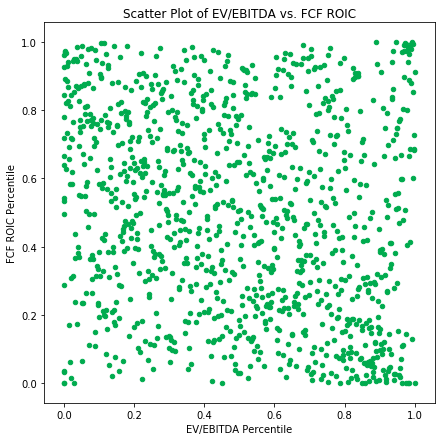

In [21]:
plt.figure(figsize=(7,7))
plt.scatter(b.EBITDAP.values, b.FCFROI.values, s=20, c=clr1[0])
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

### 4. K-Means Clustering


In [22]:
### test indexing data under multiindex framework

# a.index.names

#a[[29,73]]

a.loc[['2019-01-31'],('EBITDAP','FCFROI')]


FactorId                EBITDAP    FCFROI
Date       SecurityId                    
2019-01-31 00090Q10    0.040872  0.380995
           00163T10    0.711172  0.918552
           00164V10    0.013624  0.170136
           00287Y10    0.542234  0.095928
           00766T10    0.349682  0.353846
...                         ...       ...
           ZAYO        0.195277  0.663348
           ZBRA        0.623978  0.083258
           ZCVVV       0.960945  0.596833
           ZION        0.256131  0.370136
           ZMRH        0.628520  0.508597

[1114 rows x 2 columns]

In [485]:
# create data sample in array using 1/31/2019
dsamp = a.loc['2019-01-31',('EBITDAP','FCFROI')].values

# create kmeans object
kmeans = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans.fit(dsamp)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(dsamp)

[[0.8437384  0.12959105]
 [0.71738858 0.47544391]
 [0.15989065 0.21290265]
 [0.11793667 0.82609455]
 [0.85724563 0.83995515]
 [0.51876552 0.20771446]
 [0.2558371  0.52182242]
 [0.473363   0.79429018]]


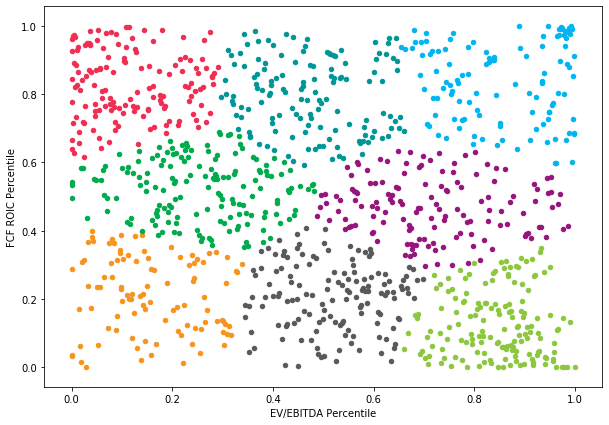

In [733]:
# Scatter plot the clusters

plt.figure(figsize=(10,7))

plt.scatter(dsamp[y_km ==0,0], dsamp[y_km == 0,1], s=20, c=clr2[0])
plt.scatter(dsamp[y_km ==1,0], dsamp[y_km == 1,1], s=20, c=clr2[1])
plt.scatter(dsamp[y_km ==2,0], dsamp[y_km == 2,1], s=20, c=clr2[2])
plt.scatter(dsamp[y_km ==3,0], dsamp[y_km == 3,1], s=20, c=clr2[3])
plt.scatter(dsamp[y_km ==4,0], dsamp[y_km == 4,1], s=20, c=clr2[4])
plt.scatter(dsamp[y_km ==5,0], dsamp[y_km == 5,1], s=20, c=clr2[5])
plt.scatter(dsamp[y_km ==6,0], dsamp[y_km == 6,1], s=20, c=clr2[6])
plt.scatter(dsamp[y_km ==7,0], dsamp[y_km == 7,1], s=20, c=clr2[7])

# plt.title("8-Means Clustering of EV/EBITDA vs. FCF ROIC - 01/31/2019")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

In [327]:
# fig2 = plty.Figure()
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==0,0], y=dsamp[y_km == 0,1], mode='markers',marker_color=clr2[0]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==1,0], y=dsamp[y_km == 1,1], mode='markers',marker_color=clr2[1]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==2,0], y=dsamp[y_km == 2,1], mode='markers',marker_color=clr2[2]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==3,0], y=dsamp[y_km == 3,1], mode='markers',marker_color=clr2[3]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==4,0], y=dsamp[y_km == 4,1], mode='markers',marker_color=clr2[4]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==5,0], y=dsamp[y_km == 5,1], mode='markers',marker_color=clr2[5]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==6,0], y=dsamp[y_km == 6,1], mode='markers',marker_color=clr2[6]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==7,0], y=dsamp[y_km == 7,1], mode='markers',marker_color=clr2[7]))
# fig2.update_layout(
#     title = 'Cluster Plot of EBITDAP vs. FCFROI',
#     yaxis_title = 'FCFROI Percentile',
#     xaxis_title = 'TTM EV/EBITDA Percentile'
# )
# fig2.show()

In [342]:
# create data sample in array using 1/31/2020
# cluster still looks similar, which indicates consistency of the pattern
dsamp2 = a.loc['2020-01-31',('EBITDAP','FCFROI')].values

# create kmeans object
kmeans2 = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans2.fit(dsamp2)
# print location of clusters learned by kmeans object
print(kmeans2.cluster_centers_)
# save new clusters for chart
y_km2 = kmeans2.fit_predict(dsamp2)

[[0.79838783 0.13259193]
 [0.13616255 0.82218528]
 [0.74816853 0.50371925]
 [0.14590643 0.215625  ]
 [0.8978744  0.86220381]
 [0.48405978 0.24011174]
 [0.48170455 0.80075671]
 [0.20944514 0.5309447 ]]


In [343]:
# sc_data.Date.unique()

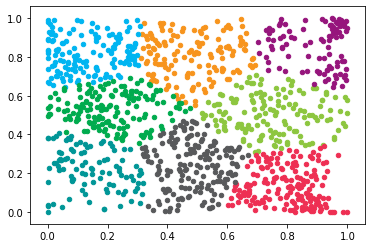

In [344]:
# Scatter plot the clusters

plt.scatter(dsamp2[y_km2 ==0,0], dsamp2[y_km2 == 0,1], s=20, c=clr2[0])
plt.scatter(dsamp2[y_km2 ==1,0], dsamp2[y_km2 == 1,1], s=20, c=clr2[1])
plt.scatter(dsamp2[y_km2 ==2,0], dsamp2[y_km2 == 2,1], s=20, c=clr2[2])
plt.scatter(dsamp2[y_km2 ==3,0], dsamp2[y_km2 == 3,1], s=20, c=clr2[3])
plt.scatter(dsamp2[y_km2 ==4,0], dsamp2[y_km2 == 4,1], s=20, c=clr2[4])
plt.scatter(dsamp2[y_km2 ==5,0], dsamp2[y_km2 == 5,1], s=20, c=clr2[5])
plt.scatter(dsamp2[y_km2 ==6,0], dsamp2[y_km2 == 6,1], s=20, c=clr2[6])
plt.scatter(dsamp2[y_km2 ==7,0], dsamp2[y_km2 == 7,1], s=20, c=clr2[7])

In [724]:
### check on some individual names to see whether there is any movements
# amzn, msft, ge, aapl, tsla
aapl = a.loc[a.index.get_level_values(1)=='AAPL',]
a.loc[a.index.get_level_values(1)=='AMZN',]
a.loc[a.index.get_level_values(1)=='GE',]
a.loc[a.index.get_level_values(1)=='CMB',] #JPM
a.loc[a.index.get_level_values(1)=='88160R10',] #TSLA
a.loc[a.index.get_level_values(1)=='G0624210',] #TEAM
a.loc[a.index.get_level_values(1)=='38259P70','BP'] #GOOG
a.loc[a.index.get_level_values(1)=='NTFZ',] #NFLX


seclist = ['AAPL','AMZN','GE','BA','CMB','88160R10','NTFZ','38259P70']

a_sub = a[a.index.get_level_values(1).isin(seclist)]

In [725]:
# update security name to tickers
a_sub.rename(index={'38259P70':'GOOG','NTFZ':'NFLX','88160R10':'TSLA','CMB':'JPM'}, inplace=True)
a_sub

BP  ChgShare   EBITDAP    FCFROI      ROIC  \
Date       SecurityId                                                     
2019-01-31 GOOG        0.666367  0.582117  0.821072  0.189593  0.224817   
           TSLA        0.868705  0.835766  0.934605  0.941176  0.934066   
           AAPL        0.780576  0.069343  0.475931  0.079638  0.067766   
           AMZN        0.916367  0.794708  0.896912  0.146606  0.354396   
           BA          0.954137  0.126369  0.752952  0.003620  0.005495   
...                         ...       ...       ...       ...       ...   
2020-02-12 AMZN        0.895018  0.788256  0.832281  0.076029  0.276268   
           BA          0.973310  0.382562  0.914337  0.995528  0.876812   
           JPM         0.284698  0.151246  0.275023  0.953488  0.550725   
           GE          0.597865  0.644128  0.399459  0.768336  0.798007   
           NFLX        0.912811  0.688612  0.553652  0.950805  0.307065   

                          TTMSP  Cluster  BP_CRank  
Date       SecurityId                               
2019-01-31 GOOG        0.823741      6.0  0.152866  
           TSLA        0.590827      4.0  0.821429  
           AAPL        0.606115      3.0  0.729167  
           AMZN        0.686151      6.0  0.783439  
           BA          0.451439      6.0  0.929936  
...                         ...      ...       ...  
2020-02-12 AMZN        0.626335      7.0  0.691824  
           BA          0.443950      0.0  0.981132  
           JPM         0.546263      2.0  0.630137  
           GE          0.200178      1.0  0.757576  
           NFLX        0.852313      1.0  0.975758  

[112 rows x 8 columns]

In [730]:
a_sub.loc[a_sub.index.get_level_values(1)=='GE',('EBITDAP','FCFROI')]




EBITDAP    FCFROI
Date       SecurityId                    
2019-01-31 GE          0.995459  0.852489
2019-02-28 GE          0.986326  0.887681
2019-03-29 GE          0.986314  0.882246
2019-04-30 GE          0.989041  0.879638
2019-05-31 GE          0.985335  0.877495
2019-06-28 GE          0.982441  0.875983
2019-07-31 GE          0.983929  0.877551
2019-08-30 GE          0.984740  0.880464
2019-09-30 GE          0.983885  0.880783
2019-10-31 GE          0.981166  0.881356
2019-11-29 GE          0.338117  0.763604
2019-12-31 GE          0.320144  0.764969
2020-01-31 GE          0.388839  0.768750
2020-02-12 GE          0.399459  0.768336

Here we plot some individual names and see where they fall. For EBITDAP vs. ROIC, Interesting to see GE, BA,TSLA & TEAM & at the same right top corner (expense & not profitable)...

Now switching to EBITDA vs. FCFROI, many interesting movements:
GE from top right to top left (expensive to cheap)
TSLA from top right to middle right (low FCFROI to moderate FCFROI)
AAPL horizontally move from left to right (great FCFROI but more expensive)
BA jump from botton left to top left (737Max impact of its profitability)


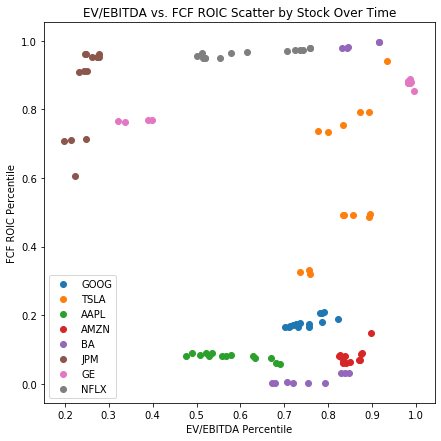

In [728]:
names = list(a_sub.index.get_level_values(1).unique())

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(names)))

plt.figure(figsize=(7,7))
for i, (name, color) in enumerate(zip(names, colors), 1):
# for i, (name) in enumerate(zip(names), 1):
    # print(a_sub.loc[a_sub.index.get_level_values(1)==name,'EBITDAP'].values)
    plt.scatter(a_sub.loc[a_sub.index.get_level_values(1)==name,'EBITDAP'].values,
                a_sub.loc[a_sub.index.get_level_values(1)==name,'FCFROI'].values, 
                label=name
                # ,c=clr2
               )

plt.title("EV/EBITDA vs. FCF ROIC Scatter by Stock Over Time")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')
plt.legend()
plt.show()



### 5. Hierachical Clustering

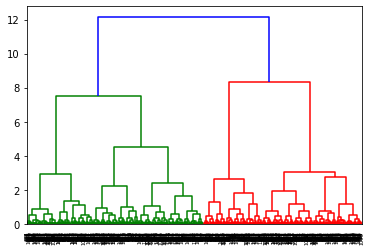

In [322]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(dsamp, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(dsamp)

### 6. Create Monthly Cluster Groupings & map it back to original dataset

In [396]:
# pd.DataFrame({'Cluster':y_km}, index = a.loc[['2019-01-31 00:00:00']].index)
a.shape[0]

15729

In [397]:
# create an empty np array to store the cuslter prediction
c_pred = np.empty(0)

for i,d in enumerate(a.index.get_level_values(0).unique()):
    datai =  a.loc[d,('EBITDAP','FCFROI')].values
    
    # create kmeans object
    kmeans = KMeans(n_clusters=8)
    # fit kmeans object to data
    kmeans.fit(datai)
    # print location of clusters learned by kmeans object
    # print(kmeans.cluster_centers_)
    # save new clusters for chart
    c_pred = np.append(c_pred,kmeans.fit_predict(datai))
    
    # print (datai)
    # print (i)

c_pred.shape
    

(15729,)

In [398]:


# # create data sample in array using 1/31/2019
# dsamp = a.loc['2019-01-31 00:00:00',('EBITDAP','FCFROI')].values

# # create kmeans object
# kmeans = KMeans(n_clusters=8)
# # fit kmeans object to data
# kmeans.fit(dsamp)
# # print location of clusters learned by kmeans object
# print(kmeans.cluster_centers_)
# # save new clusters for chart
# y_km = kmeans.fit_predict(dsamp)

In [490]:
# assign the cluster groupping back to the orginal table
c_pred_df = pd.DataFrame({'Cluster':c_pred}, index = a.index)
a['Cluster'] = c_pred_df['Cluster']
a.head()

BP  ChgShare   EBITDAP    FCFROI      ROIC  \
Date       SecurityId                                                     
2019-01-31 00090Q10    0.153777  0.801095  0.040872  0.380995  0.742674   
           00163T10    0.334532  0.958942  0.711172  0.918552  0.687729   
           00164V10    0.881295  0.028285  0.013624  0.170136  0.195055   
           00287Y10    0.964928  0.094891  0.542234  0.095928  0.077839   
           00766T10    0.127698  0.443431  0.349682  0.353846  0.808608   

                          TTMSP  Cluster  
Date       SecurityId                     
2019-01-31 00090Q10    0.253597      7.0  
           00163T10    0.941547      4.0  
           00164V10    0.263489      7.0  
           00287Y10    0.680755      3.0  
           00766T10    0.018885      0.0

### 7. Create Cluster Neutral Ranking

In [491]:
a['BP_CRank'] = a.groupby([a.index.get_level_values(0),'Cluster']).BP.rank(pct=True)
a.head()

BP  ChgShare   EBITDAP    FCFROI      ROIC  \
Date       SecurityId                                                     
2019-01-31 00090Q10    0.153777  0.801095  0.040872  0.380995  0.742674   
           00163T10    0.334532  0.958942  0.711172  0.918552  0.687729   
           00164V10    0.881295  0.028285  0.013624  0.170136  0.195055   
           00287Y10    0.964928  0.094891  0.542234  0.095928  0.077839   
           00766T10    0.127698  0.443431  0.349682  0.353846  0.808608   

                          TTMSP  Cluster  BP_CRank  
Date       SecurityId                               
2019-01-31 00090Q10    0.253597      7.0  0.148515  
           00163T10    0.941547      4.0  0.330357  
           00164V10    0.263489      7.0  0.950495  
           00287Y10    0.680755      3.0  0.916667  
           00766T10    0.018885      0.0  0.215569

(array([ 3.,  1., 10.,  8., 18., 25., 27., 30., 14., 12.]),
 array([0.03057554, 0.12607914, 0.22158273, 0.31708633, 0.41258993,
        0.50809353, 0.60359712, 0.69910072, 0.79460432, 0.89010791,
        0.98561151]),
 <a list of 10 Patch objects>)

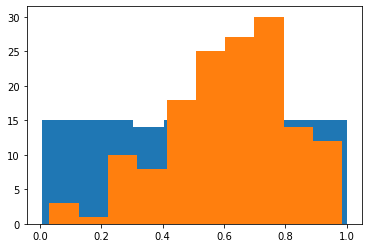

In [492]:
# some QA on the clustered rank
# looks good, the crank is unifrom for any cluster, while prank was not
test = a.loc[(a.index.get_level_values(0) == '2019-01-31 00:00:00') & (a.Cluster == 1),]['BP_CRank']
test1 = a.loc[(a.index.get_level_values(0) == '2019-01-31 00:00:00') & (a.Cluster == 1),]['BP']
plt.hist(test)
plt.hist(test1)

### 8. Getting security level return data and calc forward month return

In [433]:
# type(a.index.get_level_values(0).unique().format())

test = str(a.index.get_level_values(0).unique().format()).strip('[]')

f'IN ({test})'

"IN ('2019-01-31 00:00:00', '2019-02-28 00:00:00', '2019-03-29 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-28 00:00:00', '2019-07-31 00:00:00', '2019-08-30 00:00:00', '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2019-11-29 00:00:00', '2019-12-31 00:00:00', '2020-01-31 00:00:00', '2020-02-12 00:00:00')"

In [434]:
DateList = str(a.index.get_level_values(0).unique().format()).strip('[]')

query = f'''SELECT SecurityId, TReturn, Date, Flag
--select count(1)
FROM EquityResearch.dbo.ReturnsHistory rh
	INNER JOIN securitydb.dbo.SecurityMaster_Hist sm
		ON rh.IntegerId = sm.IntegerId
		AND rh.Date BETWEEN sm.StartDate AND sm.EndDate
		-- AND LEFT(rh.IntegerId,1) = '1' --for US names
AND rh.Date IN ({DateList})
ORDER BY rh.Date
'''

query

"SELECT SecurityId, TReturn, Date, Flag\n--select count(1)\nFROM EquityResearch.dbo.ReturnsHistory rh\n\tINNER JOIN securitydb.dbo.SecurityMaster_Hist sm\n\t\tON rh.IntegerId = sm.IntegerId\n\t\tAND rh.Date BETWEEN sm.StartDate AND sm.EndDate\n\t\t-- AND LEFT(rh.IntegerId,1) = '1' --for US names\nAND rh.Date IN ('2019-01-31 00:00:00', '2019-02-28 00:00:00', '2019-03-29 00:00:00', '2019-04-30 00:00:00', '2019-05-31 00:00:00', '2019-06-28 00:00:00', '2019-07-31 00:00:00', '2019-08-30 00:00:00', '2019-09-30 00:00:00', '2019-10-31 00:00:00', '2019-11-29 00:00:00', '2019-12-31 00:00:00', '2020-01-31 00:00:00', '2020-02-12 00:00:00')\nORDER BY rh.Date\n"

In [435]:
ret = pd.read_sql_query(query,conn)
ret.shape

(251041, 4)

In [437]:
ret.head()

SecurityId       TReturn       Date  Flag
0       AINV  1.739588e+02 2019-01-31     0
1       APLL  1.750000e-01 2019-01-31     2
2       ISOG  5.000000e-04 2019-01-31     2
3       ADSX  1.848500e-11 2019-01-31     2
4       RGSH  1.363636e-04 2019-01-31     2

In [761]:
type(universe)

pandas.core.frame.DataFrame

In [632]:
# join to unique security list to form a smaller subset
universe = pd.DataFrame({'SecurityId':a.index.get_level_values(1).unique().format()})
universe

uni_ret = pd.merge(ret, universe, how='inner', on=['SecurityId']).sort_values(['SecurityId','Date'])
uni_ret.reset_index(drop=True, inplace=True)

uni_ret['MRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change().shift(periods=-1)*100
uni_ret['QRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(3).shift(periods=-3)*100
uni_ret['HYRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(6).shift(periods=-6)*100
uni_ret['YRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(12).shift(periods=-12)*100
uni_ret

SecurityId     TReturn       Date  Flag       MRet       QRet  \
0       00090Q10   59.291279 2019-01-31     0  10.803338  -8.235779   
1       00090Q10   65.696716 2019-02-28     0 -20.125003 -26.482458   
2       00090Q10   52.475250 2019-03-29     0   3.683508  -3.161455   
3       00090Q10   54.408180 2019-04-30     0 -11.229138  -3.091726   
4       00090Q10   48.298611 2019-05-31     0   5.212693 -18.167896   
...          ...         ...        ...   ...        ...        ...   
15014       ZMRH  494.035614 2019-09-30     0   0.699340   9.214674   
15015       ZMRH  497.490601 2019-10-31     0   5.100194   7.166423   
15016       ZMRH  522.863586 2019-11-29     0   3.193147        NaN   
15017       ZMRH  539.559387 2019-12-31     0  -1.189212        NaN   
15018       ZMRH  533.142883 2020-01-31     0        NaN        NaN   

           HYRet      YRet  
0     -11.072877 -5.057135  
1     -39.839049       NaN  
2      -0.214007       NaN  
3      18.804612       NaN  
4      59.769504       NaN  
...          ...       ...  
15014        NaN       NaN  
15015        NaN       NaN  
15016        NaN       NaN  
15017        NaN       NaN  
15018        NaN       NaN  

[15019 rows x 8 columns]

In [633]:
# uni_ret['Date'] = uni_ret['Date']+' 00:00:00'
# uni_ret.head()
ret_f = uni_ret.set_index(['Date','SecurityId'])
ret_f.head()

TReturn  Flag       MRet       QRet      HYRet  \
Date       SecurityId                                                     
2019-01-31 00090Q10    59.291279     0  10.803338  -8.235779 -11.072877   
2019-02-28 00090Q10    65.696716     0 -20.125003 -26.482458 -39.839049   
2019-03-29 00090Q10    52.475250     0   3.683508  -3.161455  -0.214007   
2019-04-30 00090Q10    54.408180     0 -11.229138  -3.091726  18.804612   
2019-05-31 00090Q10    48.298611     0   5.212693 -18.167896  59.769504   

                           YRet  
Date       SecurityId            
2019-01-31 00090Q10   -5.057135  
2019-02-28 00090Q10         NaN  
2019-03-29 00090Q10         NaN  
2019-04-30 00090Q10         NaN  
2019-05-31 00090Q10         NaN

In [634]:
a.index
# ret_f.index

MultiIndex([('2019-01-31', '00090Q10'),
            ('2019-01-31', '00163T10'),
            ('2019-01-31', '00164V10'),
            ('2019-01-31', '00287Y10'),
            ('2019-01-31', '00766T10'),
            ('2019-01-31', '00847X10'),
            ('2019-01-31', '00912X30'),
            ('2019-01-31', '01527110'),
            ('2019-01-31', '01858110'),
            ('2019-01-31', '01973R10'),
            ...
            ('2020-02-12',      'YRI'),
            ('2020-02-12',      'YUM'),
            ('2020-02-12',   'YUMCWI'),
            ('2020-02-12',        'Z'),
            ('2020-02-12',      'ZAP'),
            ('2020-02-12',     'ZAYO'),
            ('2020-02-12',     'ZBRA'),
            ('2020-02-12',    'ZCVVV'),
            ('2020-02-12',     'ZION'),
            ('2020-02-12',     'ZMRH')],
           names=['Date', 'SecurityId'], length=15729)

In [495]:
# making sure the index of date matches in two df
# a.index.get_level_values(0) = 
# a.index.get_level_values(0).format()
type(a.index.get_level_values(0)) #pandas.core.indexes.base.Index
type(ret_f.index.get_level_values(0)) #pandas.core.indexes.datetimes.DatetimeIndex

pandas.core.indexes.datetimes.DatetimeIndex

### 9. Aggregate return to monthly and calc decile spread time series

In [635]:
fd = pd.merge(a, ret_f, how='inner', left_index=True, right_index=True)
# a.join(ret_f)

In [636]:
fd.index.get_level_values(0).max()

Timestamp('2020-01-31 00:00:00')

In [637]:
fd['Decile'] = np.ceil(fd.BP_CRank*10).astype(int) #.astype(str)

In [638]:
fd.tail()
fd[fd.Decile == 10]
fd.Decile.unique()
# fd.BP_CRank.describe()

array([ 8,  9,  6,  5,  3, 10,  7,  1,  4,  2], dtype=int64)

In [639]:
MthDcl = pd.DataFrame({'Ret':fd.groupby([fd.index.get_level_values(0),fd.Decile]).MRet.mean()}).reset_index()
type(MthDcl)

pandas.core.frame.DataFrame

In [640]:
MthDcl = MthDcl[MthDcl.Date != '2020-01-31']

In [641]:
MthDcl = MthDcl.pivot(index='Date', columns='Decile', values='Ret')

In [642]:
MthDcl['Spread'] = MthDcl[1] - MthDcl[10]

In [643]:
MthDcl['Cum1'] = np.cumprod(1+MthDcl[1]/100)
MthDcl['Cum10'] = np.cumprod(1+MthDcl[10]/100)
MthDcl['CumSprd'] = np.cumprod(1+MthDcl['Spread']/100)

In [644]:
MthDcl

Decile             1         2         3         4         5         6  \
Date                                                                     
2019-01-31  2.768757  3.902687  2.567097  2.987958  4.288698  4.437105   
2019-02-28 -1.485247 -0.650457 -0.322571  1.292824 -0.000300  1.035529   
2019-03-29  5.637543  4.615741  3.023105  4.188051  3.541177  3.072804   
2019-04-30 -9.377267 -6.173663 -7.132390 -6.085131 -6.812377 -7.431905   
2019-05-31  7.645286  6.995101  7.345949  6.789303  7.071840  5.800834   
2019-06-28  0.180264  1.450649  1.812593  1.281155 -0.255052 -0.178701   
2019-07-31 -7.339583 -5.336349 -4.823948 -2.692392 -3.711210 -4.745195   
2019-08-30  5.929362  4.806408  3.324868  3.229491  2.328169  2.598277   
2019-09-30 -2.205318  0.863097  0.700145  0.751506  0.794047  1.113585   
2019-10-31  2.907692  3.752624  4.100590  4.104753  1.927232  3.847192   
2019-11-29  8.672471  3.362836  5.438498  2.544446  2.378067  2.493363   
2019-12-31 -6.063062 -2.870910 -2.398258 -3.280118 -0.877209 -2.681156   

Decile             7         8         9        10    Spread      Cum1  \
Date                                                                     
2019-01-31  5.736281  3.270351  4.953551  5.180288 -2.411531  1.027688   
2019-02-28  1.408529  0.885563  1.896843 -0.402181 -1.083066  1.012424   
2019-03-29  1.451653  3.112757  5.136187  2.215175  3.422368  1.069500   
2019-04-30 -6.944194 -6.481476 -5.455082 -7.413523 -1.963744  0.969210   
2019-05-31  8.097800  8.054352  7.443208  5.245691  2.399595  1.043309   
2019-06-28  1.408392  1.260167  1.530239  2.127894 -1.947630  1.045189   
2019-07-31 -2.672863 -3.054722 -2.514807 -2.423626 -4.915957  0.968477   
2019-08-30  1.102454  1.686508  0.195494 -0.845617  6.774980  1.025901   
2019-09-30  0.389060  2.021302  1.982794  0.272054 -2.477372  1.003277   
2019-10-31  3.895036  3.240296  4.224672  3.509371 -0.601679  1.032449   
2019-11-29  2.044490  1.966579  2.120118 -0.170135  8.842606  1.121988   
2019-12-31 -0.752186 -0.552350  0.219547  2.885715 -8.948777  1.053961   

Decile         Cum10   CumSprd  
Date                            
2019-01-31  1.051803  0.975885  
2019-02-28  1.047573  0.965315  
2019-03-29  1.070778  0.998352  
2019-04-30  0.991396  0.978747  
2019-05-31  1.043401  1.002233  
2019-06-28  1.065604  0.982713  
2019-07-31  1.039778  0.934403  
2019-08-30  1.030985  0.997709  
2019-09-30  1.033790  0.972992  
2019-10-31  1.070070  0.967138  
2019-11-29  1.068249  1.052658  
2019-12-31  1.099076  0.958458

In [620]:
MthDcl.to_csv(path.join(sc_path,'clusterOutput.txt'), sep='\t')

### 10. More experiements
1. try coloring the scatter plot by forward reutrn
2. try coloring the sactter plot by cross sectional BP factor value
3. so what are the return distribution for each cluster?
4. try to use multiple factors to construct a avg Valuation factor & a avg 

In [690]:
fd.head()
# fd.shape
fd['MRtRk'] = fd.groupby([fd.index.get_level_values(0)]).MRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['QRtRk'] = fd.groupby([fd.index.get_level_values(0)]).QRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['HYRtRk'] = fd.groupby([fd.index.get_level_values(0)]).HYRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['YRtRk'] = fd.groupby([fd.index.get_level_values(0)]).YRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank



In [691]:
d1901 = fd.loc[fd.index.get_level_values(0) == '2019-01-31',]

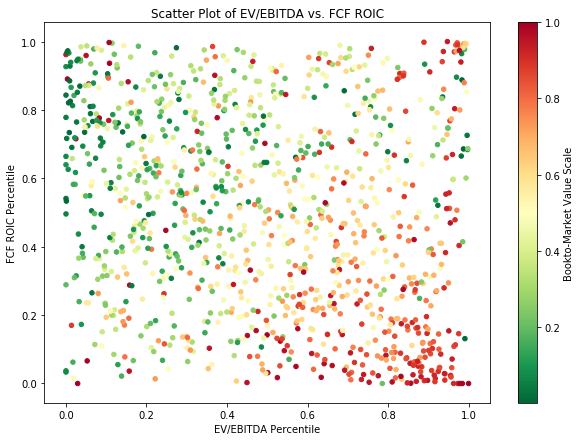

In [692]:
# color using BP rank
plt.figure(figsize=(10,7))
plt.scatter(d1901.EBITDAP.values, d1901.FCFROI.values, s=20, c=d1901.BP.values, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Bookto-Market Value Scale')
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

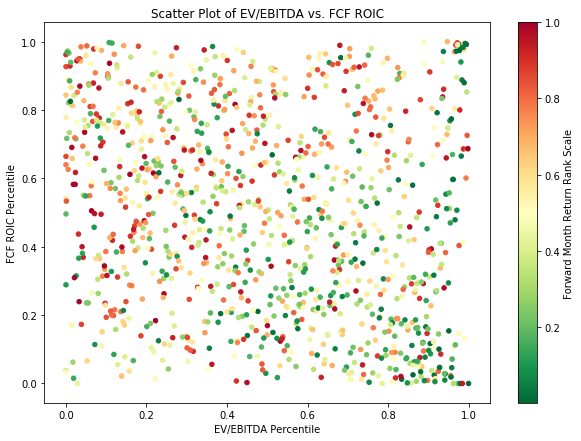

In [698]:
# color using foward return

plt.figure(figsize=(10,7))
plt.scatter(d1901.EBITDAP.values, d1901.FCFROI.values, s=20, c=d1901.MRtRk.values, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Forward Month Return Rank Scale')
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

In [755]:
# functionize it

def factor_splot(x,y,clr):
    # this function scatter plot two arrays (x & y) with the color map using clr value
    # inputs type should be pandas Series
    plt.figure(figsize=(10,7))
    plt.scatter(x.values, y.values, c=clr.values, s=20, cmap='RdYlGn_r')
    cbar = plt.colorbar()
    cbar.set_label(f'{clr.name} Scale')
    plt.title(f"Scatter Plot of {x.name} vs. {y.name}")
    plt.xlabel(f'{x.name} Percentile')
    plt.ylabel(f'{y.name} Percentile')
    
    plt.show()


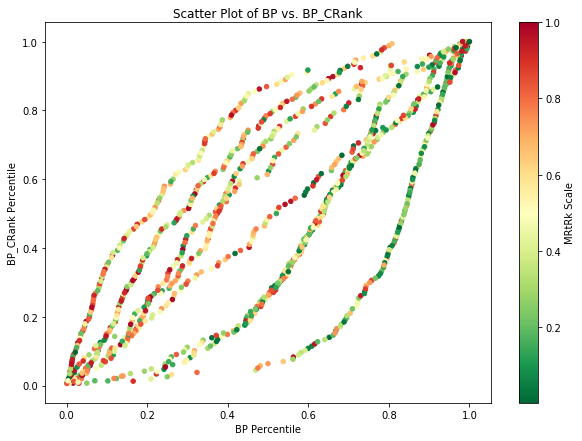

In [758]:
# factor_splot(x = d1901.BP, y = d1901.EBITDAP, clr=d1901.MRtRk)
factor_splot(x = d1901.BP, y = d1901.BP_CRank, clr=d1901.MRtRk)

In [ ]:
# Return distribution for each cluster



In [754]:
fd.head()


BP  ChgShare   EBITDAP    FCFROI      ROIC  \
Date       SecurityId                                                     
2019-06-28 PNW         0.326690  0.640175  0.257243  0.766812  0.606702   
2019-02-28 03748R10    0.663357  0.127173  0.631723  0.918478  0.819432   
2019-08-30 ATO         0.411869  0.897138  0.531418  0.926851  0.668767   
2019-04-30 74051N10    0.436823  0.156881  0.371689  0.058824  0.998170   
2019-05-31 92247510    0.913043  0.848678  0.925756  0.072595  0.164070   

                          TTMSP  Cluster  BP_CRank       TReturn  Flag  \
Date       SecurityId                                                    
2019-06-28 PNW         0.534662      5.0  0.710345  10532.299805     0   
2019-02-28 03748R10    0.881769      7.0  0.868966   1359.798950     0   
2019-08-30 ATO         0.709477      0.0  0.558282  10909.280273     0   
2019-04-30 74051N10    0.511733      0.0  0.555556    108.417603     0   
2019-05-31 92247510    0.985507      0.0  0.763636    415.204498     0   

                            MRet       QRet     HYRet  YRet  Decile     MRtRk  \
Date       SecurityId                                                           
2019-06-28 PNW         -2.266363   4.001317 -2.842020   NaN       8  0.747387   
2019-02-28 03748R10     2.779530   2.876608  5.857189   NaN       9  0.375455   
2019-08-30 ATO          3.320290  -2.446634       NaN   NaN       6  0.470222   
2019-04-30 74051N10    10.592834  16.611506 -1.956052   NaN       6  0.022645   
2019-05-31 92247510     5.068391   3.947118 -3.311937   NaN       8  0.606171   

                          QRtRk    HYRtRk  YRtRk  
Date       SecurityId                             
2019-06-28 PNW         0.384413  0.745808    NaN  
2019-02-28 03748R10    0.338504  0.424494    NaN  
2019-08-30 ATO         0.790179       NaN    NaN  
2019-04-30 74051N10    0.087432  0.597248    NaN  
2019-05-31 92247510    0.514181  0.818767    NaN